# Northern Michigan Snowfall Prediction using Machine Learning Models 
### Or:  If a Decision Tree Falls in the Snow in a Random Forest, Will Anyone Hear It?



#### Supervised Machine Learning 

![photo of Sault Ste. Marie area power canal](../Media/snowmobile-I-500.png)

How accurately can I create a model that can predict whether there will be snowfall on any given day, or just Christmas Day in Sault Ste. Marie, Michigan? 
Sault Ste. Marie is located at the top of the Upper Peninsula, in Northern Michigan. It comes from the French, so it's pronounced "Soo Saint Marie, " or "the Soo," for short. The city's name comes from Saults de Sainte-Marie, archaic French for "Saint Mary's Falls", a reference to the rapids of Saint Marys River. 

Pristine lakes and waterfalls, my favorite people in the world and abundant trees make this one of my favorite places on Earth. Given it's north of the 45th parallel, it's not the warmest year-round. There can be snow on the ground for some six months of the year, lasting from late October with the last bits finally disappearing around the beginning of May. So it's not a stretch to predict if there will be snow on the ground in December - but will there be a new blanket of fresh white snow to wake up to on Christmas Day?  That may take a bit more finesse to figure out. 

We gathered datasets from weather stations in and near Sault Ste. Marie in order to have a more robust dataset. Links to the data from the National Centers for Environmental Information/ NOAA can be found [here](https://www.ncei.noaa.gov/access/past-weather/49783).
There is a single dataset from a weather station at Sanderson Field in this study.  A study of all of the area weather station data will be done in a separate notebook. 

In [13]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier #can handle NANs
from sklearn.ensemble import HistGradientBoostingRegressor #can handle NANs


In [99]:
from scipy import stats

Dates can be a little tricky to format for machine learning, so initially, I'm going to see if we can predict snowfall for any given day. Later, I'll narrow down the dates to just Christmas and compare the two. Speaking of dates, this dataset begins January 1, 1948 and runs to November 28, 2022.  Data was collected from Sanderson Air Field in Sault Ste. Marie and downloaded from [this link](https://www.ncei.noaa.gov/access/past-weather/49783). 

In [103]:
snow = pd.read_csv(r"..\DATA\Sault-Weather.csv")

In [104]:
snow.head()

,Date,AvgTemp,MaxTemp,MinTemp,Precip,Snowfall,SnowDepth,Unnamed: 7
0,1/1/1948,NaN,19.0,2.0,0.00,0.0,12.0,NaN
1,1/2/1948,NaN,33.0,11.0,0.00,0.0,11.0,NaN
2,1/3/1948,NaN,27.0,9.0,0.00,0.0,10.0,NaN
3,1/4/1948,NaN,31.0,22.0,0.17,3.4,14.0,NaN
4,1/5/1948,NaN,30.0,23.0,0.01,0.3,13.0,NaN


In [105]:
snow = snow.drop(['AvgTemp', 'Unnamed: 7','Date'], axis = 1, inplace = True)

In [106]:
snow.head()

,MaxTemp,MinTemp,Precip,Snowfall,SnowDepth
0,19.0,2.0,0.00,0.0,12.0
1,33.0,11.0,0.00,0.0,11.0
2,27.0,9.0,0.00,0.0,10.0
3,31.0,22.0,0.17,3.4,14.0
4,30.0,23.0,0.01,0.3,13.0


In [72]:
len(snow)


27361

In [73]:
27361 * 6

164166

In [108]:
print(snow.isna().sum()) #number of NAs in each column - note these NAs may be in different rows. For instance, an NA in a particular row in one column may not have more NAs across the same row. 

MaxTemp       23
MinTemp      204
Precip         2
Snowfall     660
SnowDepth    663
dtype: int64


In [107]:
print(snow.isna().sum().sum()) #total number of NAs 

1552


In [75]:
1552/164166 # = percentage of NAN cells in dataset

0.009453845497849738

.9 % of overall cells in dataset are null values, so it's safe to just drop them. It won't affect results. 

In [102]:
#check to see how many rows are present before dropping NAs - 
snow.shape

(24952, 5)

In [92]:
snow = snow.dropna()

In [ ]:
#check to see how many rows are lost after dropping NAs - 
snow.shape

Keeping all values in the Snowfall column that are not equal to zero. In other words, we're removing the zeroes for when snowfall was recorded. For the vast majority, the zeroes occur during the spring, summer and fall months (which are six months of the year). Later, when graphing the linear regression, we found that all of the zeroes skewed the distribution. More on that below. 
However, removing the days it doesn't snow removes the chance for the model to learn what it takes to "not snow." learns from the absence of conditions to produce snow. Something to consider. "isn't learning from its mistakes."  check boosting - 

In [78]:
snow = snow[snow['Snowfall'] != 0   ]



After removing the zeroes, we removed other outliers, three standard deviations on each side of the distribution. 

In [100]:
#remove outliers.  Absolute value of the standard dev from z score, on each value in each column (six sigma)
snow = snow[(np.abs(stats.zscore(snow)) < 3).all(axis=1)]
snow.head()


,MaxTemp,MinTemp,Precip,Snowfall,SnowDepth
0,19.0,2.0,0.00,0.0,12.0
1,33.0,11.0,0.00,0.0,11.0
2,27.0,9.0,0.00,0.0,10.0
4,30.0,23.0,0.01,0.3,13.0
5,31.0,22.0,0.09,2.1,14.0


In [109]:
#checking now to see if zeroes remain

snow.min()

MaxTemp     -12.0
MinTemp     -36.0
Precip        0.0
Snowfall      0.0
SnowDepth     0.0
dtype: float64

In [80]:
#removing high outliers, from extreme snow events in 1972 and 1995. We're keeping all values less than 40 inches of snowfall. 

snow = snow[snow['Snowfall'] < 40 ]

In [81]:
# y consists of the target variable, or what I'm trying to predict. X is the group of variables that will be used to learn how to predict the y variable - or snowfall.

x = snow[['MaxTemp', 'MinTemp', 'Precip', 'SnowDepth']]
y = snow['Snowfall']


#### Train Test Split
One of the key things that separates machine learning from statistics is that machine learning utilizes the concept of "train test split." In statistics, you typically run your analysis on all the data you have available. In machine learning, you split your data in half, and reserve the first chunk for training the model, and the second half for testing the model. How big should a "chunk" be? Typically you want more data to be used for training than for testing. 80/20, 70/30, and 60/40 splits are all acceptable.


You will utilize the train_test_split() function from sklearn to split your data. You will end up with four data sets at the end:


* x_train
* x_test
* y_train
* y_test

There will be one training dataset and one testing dataset each for x and y.

In [83]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .25)

#reduced to 25/75 split to give more opportunity to train the model. 

In [84]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4397, 4) (4397,)
(1466, 4) (1466,)


This is showing that in the training datasets, there are 4397 rows and 4 columns, and in the testing dataset, there are 1,466 rows and 4 columns. So you can see how the training and testing data is broken up.

#### Creating a linear Regression Model

Any time one hears the word regression, it means there is something being predicted. A linear regression is a numberic value, and a logistic regression is a categorical variable that's being predicted. 

In [58]:
lm = LinearRegression() 
lm.fit(x_train, y_train)

LinearRegression()

Model is created, now I can examine its predictions: 

In [59]:
predictions = lm.predict(x_test)
predictions

array([0.66998241, 0.59969743, 2.19733097, ..., 1.27423835, 0.25120157,
       0.51666162])

This information is not super useful by itself, but plotting it gives us a better idea of how accurate our predictions (and thus our model) is. The straighter the line, the better the model fit. We'll make a scatterplot with the plt.scatter() function, graphing the y_test data against the predictions from our training model:

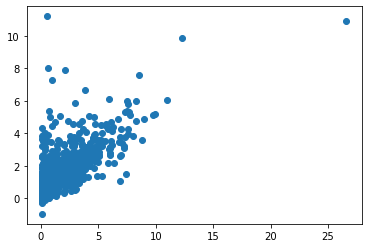

In [60]:
plt.scatter(y_test, predictions)

#drop zero snowfall measures which is probably the Junes, Julys and Augusts - 
#look at z score and eliminate anything more than 3 std 

This is not a linear model, so a linear regression isn't the right model for this dataset. I will say that before the zeroes were removed for snowfall (which were largely the spring, summer and fall days when no snow fell), the model graph was distributed differently. 
To work on further, we'll do a grid search - but not Support Vector Machines (SVM), we don't believe it's going to be effective in this case. We'll try random forest regressor and decision trees. I won't fine tune them just yet - I would like to see which model performs more accurately before fine tuning. Then I'll go with that one. 


#### Accuracy Score

In [61]:
print("Score:", lm.score(x_test, y_test))

Score: 0.503826010368406


the accuracy of this linear model is 50%. Half the time, our model could accurately predict if it is going to snow on a particular day during the winter months in Sault Ste. Marie, Michigan.  

Before the zeroes were removed, this model was accurate some 20% of the time - not very reliable, is it? Accuracy took a hit when the model was trying to predict if snow would fall in July, for instance. We had fed it misleading information at first. Removing the zeroes, or summer days, helped the model greatly. 

### K-Folds Cross Validation

K-Folds Cross Validation is one method I could try to improve the accuracy of the model - The idea behind k-folds cross validation is that you don’t want to rely on just one iteration of train-test-split, because it could be biased accidentally. So if one is good, isn’t more better? You can create as many iterations of training as you like, with the number of iterations indicated as k. 

If you break down k-fold categorization into its most basic components, here is what this function does:

Randomizes the data
Splits the data into groups (k #)
For each group, creates a test set and a training set, then fits a model and retains the accuracy score
Summarizes the model using each iteration’s accuracy score
Each separate group of data will the testing data once, and will be used as training data for the remainder of the iterations.

#### Import Packages for K-fold 

In [110]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [111]:
kfold = KFold(n_splits =3, shuffle = True, random_state= 1)
for train, test in kfold.split(x,y):
    print('train: %s, test: %s' % (train,test))

train: [   0    1    2 ... 5859 5860 5861], test: [   3    4    5 ... 5855 5858 5862]
train: [   0    2    3 ... 5858 5860 5862], test: [   1    6    7 ... 5857 5859 5861]
train: [   1    3    4 ... 5859 5861 5862], test: [   0    2    8 ... 5854 5856 5860]


In [112]:
print(cross_val_score(lm, x,y, cv=5))

[0.5556295  0.48200759 0.5439801  0.33544596 0.54755155]


Using kfold, the first trained model could accurately predict snowfall 55% of the time, the second  model was accurate 48% of the time, third was 54%, fourth was 33% and the fifth model rounded out the effort with a 54% accuracy rate. 

Again before removing outliers, the first trained model was accurate 16 % of the time, while the second and third models could accurately predict snow just 22% of the time and the fourth model was accurate 18% of the time while the fifth trailed in at 19% accuracy. 

### Decision Tree Regressor 
Or:  If a Decision Tree Falls in the snow in a Random Forest, will anyone hear it?

 A decision tree regressor is a more powerful model compared to the linear regression seen above, and perhaps more applicable since that wasn't a linear distribution. The power of decision trees lies within its ability to identify nonlinear relationships within the data.

Other tree methods can introduce multicollinearity, meaning that it makes the trees too highly correlated. If we average things that are already a lot alike, we are not reducing variability and instead are introducing bias. But random forests randomizes everything equally and can thus reduce bias and prevent the tree outcomes from overlapping excessively. Random forests are also an awesome choice because there are no assumptions to test for, we don't need to scale any variables, and the model itself doesn't need a lot of playing around to get a good fit right off the bat.
However, decision trees are not without their downsides. While decision trees are great for complex datasets, they overfit the data and as a result do not generalize well. This would make is extremely difficult to model and predict something already unpredictable: the weather. 

Both decision trees and random forests are classification models, which means that they are meant to correctly categorize, or classify, the y variable.  Additionally, we'll need the following for Decision Trees. 


In [124]:
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


### Create Initial Decision Tree
Before we wander into the Random Forest, we'll try a single decision tree. To do this, we'll use the DecisionTreeClassifier() function and then fit() the model. 

In [115]:
decisionTree = DecisionTreeRegressor ()
decisionTree.fit(x_train, y_train)

DecisionTreeRegressor()

In [138]:
print("Score:", decisionTree.score(x_test, y_test))

Score: 0.3186195711296781


In [ ]:
31

### Assess the Model
Now that the data is fit, the next step is to create a set of predictions and interpret the results. We can start by using the predict() function, and then we'll use the same confusion matrix and classification report coding as we did above did last lesson.


In [120]:
treePredictions = decisionTree.predict(x_test)

In [121]:
print(treePredictions)

[0.1 5.8 7.8 ... 2.1 0.9 0.8]


### Now to print out the confusion matrix

In [148]:
#print(confusion_matrix(y_test, treePredictions))

### Now, on to the Random Forest - full of trees 

In [142]:
#Create a Random Forest Regressor 

rf = RandomForestRegressor(n_estimators=100,max_depth= 8,) #accuracy might go down, but fewer errors .important to not overfit 

In [143]:
#Train the model on the weather data 

rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=8)

In [144]:
#Use this trained model to make predictions on the test data: will it snow? 

y_pred =  rf.predict(x_test)

In [141]:
# print the predictions as a comma-separated list. We can adjust the separator string (in this case, ', ') to any value.
# commenting out since the list is quite lengthy.
#print(*y_pred, sep = ", ")
#to run short summary, use
#print(y_pred)

When trying to evaluate the performance of a regression model (i.e. a model that predicts continuous values instead of categorical class labels), we can use different evaluation metrics such as mean absolute error, mean squared error, and R-squared.



In [145]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Print the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

# Print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Print the R-squared score
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)


Mean Absolute Error: 0.5540554639944211
Mean Squared Error: 0.8635704954704854
R-squared: 0.6508375128163051


In [137]:
#Lower values for the mean absolute error and mean squared error, and a higher value for R-squared indicate a better fit.

### Interpretations of the Random Forest

The mean absolute error tells us, on average, how far off our predictions are from the true values. In our case, the mean absolute error is .59, which means that our predictions are, on average, .59 days away from the true values.
The mean squared error tells us how much error there is in our predictions, on average. In our case, the mean squared error is .946, which means that our predictions are, on average, .95 days away from the true values.
The R-squared score tells us how well our predictions match the true values. In our case, the R-squared score is 0.61, which means that our predictions explain 61% of the variation in the true values. This is a good score, but there is still room for improvement.




In [ ]:
# sign of overfitting - fine tune rf by limiting number of splits - general rule around 6-8 splits is healthy - 

In [147]:
print("Score:", rf.score(x_test, y_test))

Score: 0.6508375128163051


# Future growth on this project

- figure out how to bin labels and turn into categorical/classification problem 
